Evaluate the initial performance of the MedSAM off-the-shelf (code copied from example notebook) (https://colab.research.google.com/drive/19WNtRMbpsxeqimBlmJwtd1dzpaIvK2FZ?usp=sharing#scrollTo=MBWWGgitt9D2). 

Please download the model medsam_vit_b.pth to your directory ahead of running this notebook. https://drive.google.com/drive/folders/1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN

Clone both of the following repository as well. Some files from axondeepseg are changed slightly so that the import statements work outside the packages. Please reference the repo for these changes.

In [15]:
import cv2
!git clone https://github.com/axondeepseg/axondeepseg.git
!git clone https://github.com/bowang-lab/MedSAM

fatal: destination path 'axondeepseg' already exists and is not an empty directory.
fatal: destination path 'MedSAM' already exists and is not an empty directory.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
from axondeepseg.AxonDeepSeg.testing.segmentation_scoring import Metrics_calculator

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [27]:
def eval_image(img, ground_truth, plot=False):
    img_np = io.imread(img)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    
    box_np = np.array([[95, 255, 190, 350]])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)
    
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_3c)
        show_box(box_np[0], ax[0])
        ax[0].set_title("Input Image and Bounding Box")
        ax[1].imshow(img_3c)
        show_mask(medsam_seg, ax[1])
        show_box(box_np[0], ax[1])
        ax[1].set_title("MedSAM Segmentation")
        plt.show()
    
    # calculate dice score
    ground_truth_mask = cv2.imread(ground_truth)
    m = Metrics_calculator(medsam_seg,ground_truth_mask)
    return m.pw_dice()
    

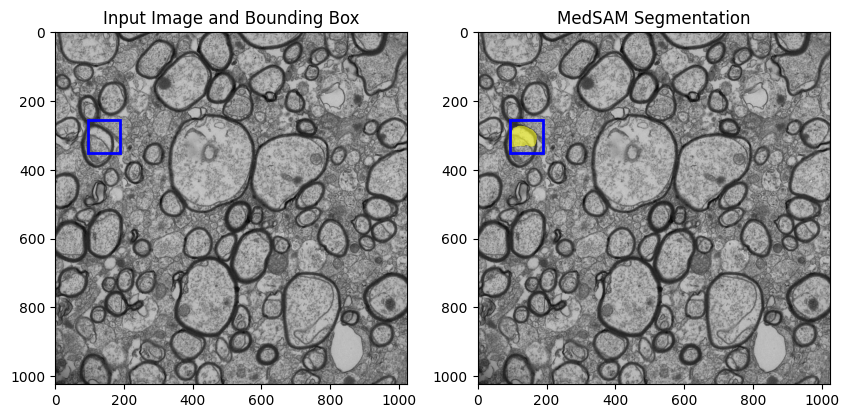

In [28]:
# plot the performance of this image, for instance
eval_image('datasets/zenodo/images/7_EM1_3_10D_N_P_0002.png', 'dataset/zenodo/labels/7_EM1_3_10D_N_P_0002.png', plot=True)

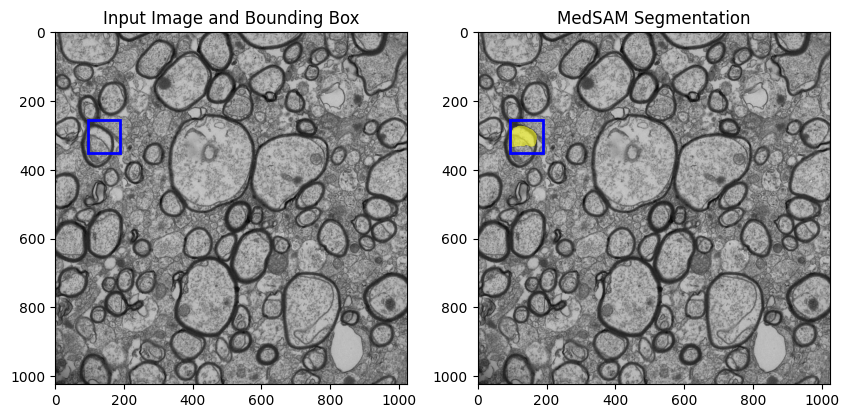